<a href="https://colab.research.google.com/github/foxtrotmike/MIL/blob/master/milgen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Why random patch selection from Pathology images is a good idea

If we select a random patch from an image during training in each step then, even if the probability of it being useful for our learning problem is low (say p = 0.01), the over n iterations of selecting patches, the probability that no useful patch was selected is $Q(n) = (1-p)^n$ which decays very fast. Thus, we should select a patch at random from a given WSI during training. Below is a plot of Q vs n.





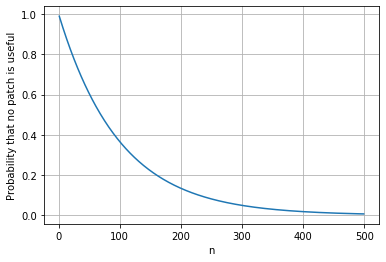

In [18]:
import numpy as np
import matplotlib.pyplot as plt

n = np.arange(1,500)
p = 0.01
Q = (1-p)**n
plt.plot(n,Q);plt.xlabel('n');plt.ylabel('Probability that no patch is useful'); plt.grid()


# Why we should retain the maximum scoring patch in each image

Together with random patch selection, it may be a good idea to retain the maximum socring patch in each WSI image during training. We cannot fit all patches from the slide in memory with existing GPUs. However, we can do a sort of a stochastic hill-climbing based approach for getting a good patch from each WSI.

This is demonstrated below with a simple experiment: Assume we have a huge array (here Z with 1000 elements) that we cannot fit all into memory and we want to find the maximum scoring element. We can pick a few random elements from the array that we can fit into memory and calculate the max of these elemnts as in the algo below. We do it repeatedly and, as you can see below, we converge very quickly to a good approximation of the actually max (much earlier than iterating through the whole array!)

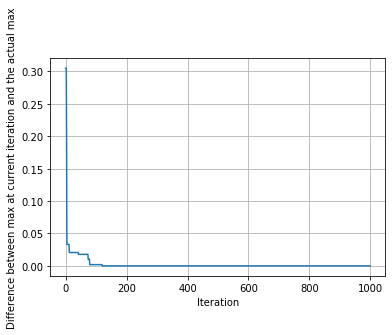

In [20]:
n = 1000
s = 3
Z = np.random.rand(n)
def randMax(Z,s = 1):
  M = -np.inf
  MaxSoFar = []
  for i in range(n):
    m = np.max(np.random.choice(Z,s))
    if m>M:
      M = m
    MaxSoFar.append(M)
  return np.array(MaxSoFar)

Max_s = randMax(Z,s = 3)
ActualMax = np.max(Z)
plt.plot(ActualMax-Max_s)
plt.ylabel('Difference between max at current iteration and the actual max')
plt.xlabel('Iteration')
plt.grid()

# Conclusion: 

We should select a number of patches from a given image in each iteration and keep a tally of the current maximum scoring patch from a WSI. We can do this for multiple images in the training set at the same time.

The code below shows some ideas on how this can be done in PyTorch.

In [22]:
# -*- coding: utf-8 -*-
"""
Created on Tue Dec 17 01:47:34 2019
How to do MIL when the bag just won't fit into memory: Use hill climbing search
This should require significantly less number of bags in comparison to the Fuchs paper
(https://arxiv.org/abs/1805.06983)
Idea: (inspired from ESMIL)
In each iteration
  Chose a positive and a negative bag (WSI)
  Load random examples (patches) from a bag (WSI)
  Append to it, the last max scoring example of the bag
  Evaluate all examples in the bag using the given model
  Save max scoring example of the bag to file
  Compute loss based on the positive and negative bag
  Backpropagate
Assumptions: Each bag (WSI) has an ID and there is an efficient way to load random examples (patches) for a bag (WSI)
Losely Based on: https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
@author: Fayyaz Minhas
"""
import numpy as np
import torch
from torch.utils import data

class MILDataset(data.Dataset):
  'Characterizes a Multiple Instance dataset for PyTorch'
  def __init__(self, list_IDs, labels, maxsize = None):
        'Initialization'
        self.labels = labels #dictionary of id to label
        self.list_IDs = list_IDs #list of ids
        self.maxsize = maxsize #max size to load at once
  def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]
        if self.maxsize is None:
          maxsize = 10 #load all?
        else:
          maxsize = self.maxsize
        #Load random examples (patches) from bag file (WSI) based on ID   
        # Preferably a fast mechanism of loading random patches
        X = np.random.rand(maxsize,2) #temporary random data
        # load the top scoring patch (example) for this id if it exists
        #xtop = load('data/' + ID + '.top')
        xtop = np.random.rand(1,2) #temporary random data
        # can do data augmentation as well if required here
        X = np.vstack((X,xtop))
        y = self.labels[ID]
        return X,ID,y
    
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
#cudnn.benchmark = True
max_iters = 10 #ensure that each bag is selected multiple times
# Datasets
partition = {'pos': ['id-1', 'id-2', 'id-3'], 'neg': ['id-4','id-5']}# IDs (bag ids or WSI names)
labels = dict([(k,1.0) for k in partition['pos']]+[(k,-1.0) for k in partition['neg']]) 
# Generators (for positive and negative bags)
posgen = data.DataLoader(MILDataset(partition['pos'], labels), pin_memory = True, shuffle = True) #disable pin_memory if the data cannot fit into GPU memory
neggen = data.DataLoader(MILDataset(partition['neg'], labels), pin_memory = True, shuffle = True)
positer, negiter = iter(posgen), iter(neggen)
# Loop over epochs
for i in range(max_iters):
  # Selecting a positive and a negative bag randomly
    try: #not pretty but works!
      PX,Pid,_ = next(positer)
    except StopIteration:
      positer = iter(posgen)
      PX,Pid,_ = next(positer)
    PX,Pid = PX[0],Pid[0]
    # pass each example one by one .to(device) and score the max (try with all at once as well)
    try:
      NX,Nid,_ = next(negiter)
    except StopIteration:
      negiter = iter(neggen)
      NX,Nid,_ = next(negiter)
    NX,Nid = NX[0],Nid[0]
    # pass each example one by one .to(device) and score the max (try with all at once as well)
    print(i,Pid,Nid)
  # TODO: compute score over PX and NX. Save top scoring patch of each to a file
    # so it can be loaded
  # TODO: Comput loss and backpropagate

0 id-1 id-5
1 id-3 id-4
2 id-2 id-4
3 id-1 id-5
4 id-2 id-4
5 id-3 id-5
6 id-3 id-4
7 id-1 id-5
8 id-2 id-5
9 id-2 id-4
